# Topic Models

Last week we talked about so-called "supervised" machine learning methods for text. This week we'll be talking about "unsupervised" machine learning models. Unsupervised models help us to identify latent structure or make generalizations about unlabeled data, so they're especially helpful when we have a lot of documents and want to gain some additional insights on what they're about.

To start, install (or at least attempt to install) these packages first. Then restart the kernel. We'll use them later in the class.

In [ ]:
%pip install pyLDAvis
%pip install wordcloud


In [ ]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from sklearn.decomposition import LatentDirichletAllocation

import math
import time

import pyLDAvis
from pyLDAvis import lda_model
from IPython.display import display, HTML



We'll start by reading in some example data. This .csv contains articles scraped from CNN and Fox News from around 2020. 

In [ ]:
articles = pd.read_csv('https://github.com/Neilblund/APAN/raw/main/news_sample.csv')
# stripping some excess whitespace
articles['headline'] = articles.headline.str.strip()
articles.head()

We'll also apply a function the URL to make a clickable link that that we'll use later:

In [ ]:
articles['hyperlink']=articles.apply(axis=1, func = lambda x: f'<a href={x.url}>{x.headline}</a>')


# Pre-processing data


We'll also do some additional pre-processing of our data. In the supervised learning case, we were careful to split out data up into training and test sets. Although there can be some situations where that's useful, its less important when it comes to unsupervised models because our ultimate goals here are more descriptive rather than predictive. 

The basic steps here are still similar: we split each document up into a list of words and then create an array (called `dfm` here) that has one column for each term in the collection of texts, and one row for each article:

In [ ]:

eng_stopwords = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return [stemmer.stem(token).lower() for token in tokens if token not in eng_stopwords and token.isalpha()]




vectorizer = CountVectorizer(analyzer = 'word',
                             tokenizer = tokenize,
                             ngram_range=(0,1), # Tokens are individual words for now
                             strip_accents='unicode',
                             max_df = 0.1, # maximum number of documents in which word j occurs. 
                             min_df = .0025 # minimum number of documents in which word j occurs. 
                            )


dfm = vectorizer.fit_transform(articles['text'])

# get the names of the features for future use
features = vectorizer.get_feature_names_out()


## Describing texts

In a previous class, we talked about using a sentiment dictionary to identify whether newspaper coverage was generally positive or negative over time for a particular topic. A different exploratory approach might be to just look at what terms are more strongly associated with Fox News compared to CNN.

The `calcKeyness` function included in the `text_functions.py` file will give us a way to compare term frequencies in CNN articles vs. Fox News articles based on their relative log 2 odds ratios. The general usage will be something like: 
`calcKeyness(X, y)` where `X` is the sparse matrix that we get from using `CountVectorizer` and `y` is a boolean vector that equals False for the "baseline" category and "True" for the category we want to compare against. 

The code below is going to calculate the odds ratio for terms that appear in CNN articles (positive values) compared to terms that show up more often in Fox News articles:

In [ ]:
from text_functions import calcKeyness

In [ ]:
keyterms = calcKeyness(dfm,                         # the document-term matrix
                       articles['source'] == "CNN", # True if the article is from CNN (False for Fox News)
                       minimum_threshold=200,       # remove words that occur less than 200 times
                       feature_names=features)      # including the vocabuly so we have labels for each term


The negative values are terms more strongly associated with Fox News articles:

In [ ]:
keyterms.head()

The postive `oddsratio` values represent terms that are positively associated with CNN:

In [ ]:
keyterms.tail()

A visualization can also be helpful for getting a sense of these results. If you were following the news in 2020, you might be able to spot some terms associated with stories that were in the news around that time:

In [ ]:
top_bottom = pd.concat([keyterms.iloc[:15], keyterms.iloc[-15:]])
ax = sns.barplot(data=top_bottom,
                 y= 'term',    
                 hue='term',
                x=top_bottom['oddsratio'],dodge=False, palette='turbo')
ax.set(xlabel='Term associations Fox News (negative values) vs. CNN (positive values)', ylabel='term')

We can also make a word cloud, either for the entire corpus, or separately for each source. 

(wordclouds are not necessarily a great way to visualize text, but they look cool and people like them, so there's something to be said for playing the hits)

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate_from_frequencies(dict(zip(vectorizer.get_feature_names_out(), dfm.toarray().sum(axis=0))))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Or, we can compare CNN to Fox side by side:

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

cnn_dfm = dfm[np.where(articles['source'] == "CNN")]

cnn_wordcloud = WordCloud().generate_from_frequencies(dict(zip(vectorizer.get_feature_names_out(), cnn_dfm.toarray().sum(axis=0))))
axes[0].imshow(cnn_wordcloud, interpolation='bilinear')
axes[0].axis("off")
axes[0].set_title("CNN")

fox_dfm = dfm[np.where(articles['source'] == "Fox News")]
fox_wordcloud = WordCloud().generate_from_frequencies(dict(zip(vectorizer.get_feature_names_out(), fox_dfm.toarray().sum(axis=0))))
axes[1].imshow(fox_wordcloud, interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title("Fox News")

plt.show()

# Describing Textual Data





## Text Analysis - Topic Modeling

We know that terms like "migrant", "immigrant", "border" etc. probably all reference the same kind of story, but our bag-of-words method fails to capture even fairly obvious relationships like this. Topic modeling is a way to represent text documents as a collection of "themes" or related ideas rather than just using a generic bag of words.

We'll apply **Latent Dirichlet Allocation** (LDA), a common method for topic modeling, to these texts. This should allow us to identify general themes associated with our documents, and potentially give us a way to speak more generally about differences in how Fox and CNN cover the news without having to rely solely on counting how frequently different terms are occurring.


### Latent Dirichlet Allocation

LDA is a statistical model that generates groups based on similarities. This is an example of an **unsupervised machine learning model**. That is, we don't have any sort of outcome variable -- we just need to have some very rough idea regarding the number of topics in our corpus, and the LDA model will identify them for us. 

A dirichlet distribution is a probability distribution that can be used to describe the probability for multivariate outcomes. For instance, if we were manufacturing a bunch of unbalanced dice, I could use a random dirichlet distribution to model the probability of each face:

In [ ]:
# 10 random unbalanced dice: 
rng = np.random.default_rng()
s = pd.DataFrame(rng.dirichlet((1,1,1,1,1,1), 10), columns = range(1, 7, 1))


In [ ]:
s.plot.barh(stacked=True)

In LDA, we assume that documents themselves are created by sampling from two dirichlet distributions:


- The **Topic-word distribution** (sometimes called phi or beta)  models the probability of any word occuring in a single topic. A topic related to Covid-19 might have a high probability of terms like "Fauci", "mask", or vaccine". A topic related to the election might have a high probabiltiy of "vote", "caucus" or "turnout"
- The **Document-Topic distributions** (theta) models the probability of drawing one of K topics within a given document. So a document might be drawn 75% from the Covid-19 topic, 20% from the election topic, and 5% from some other random topic.

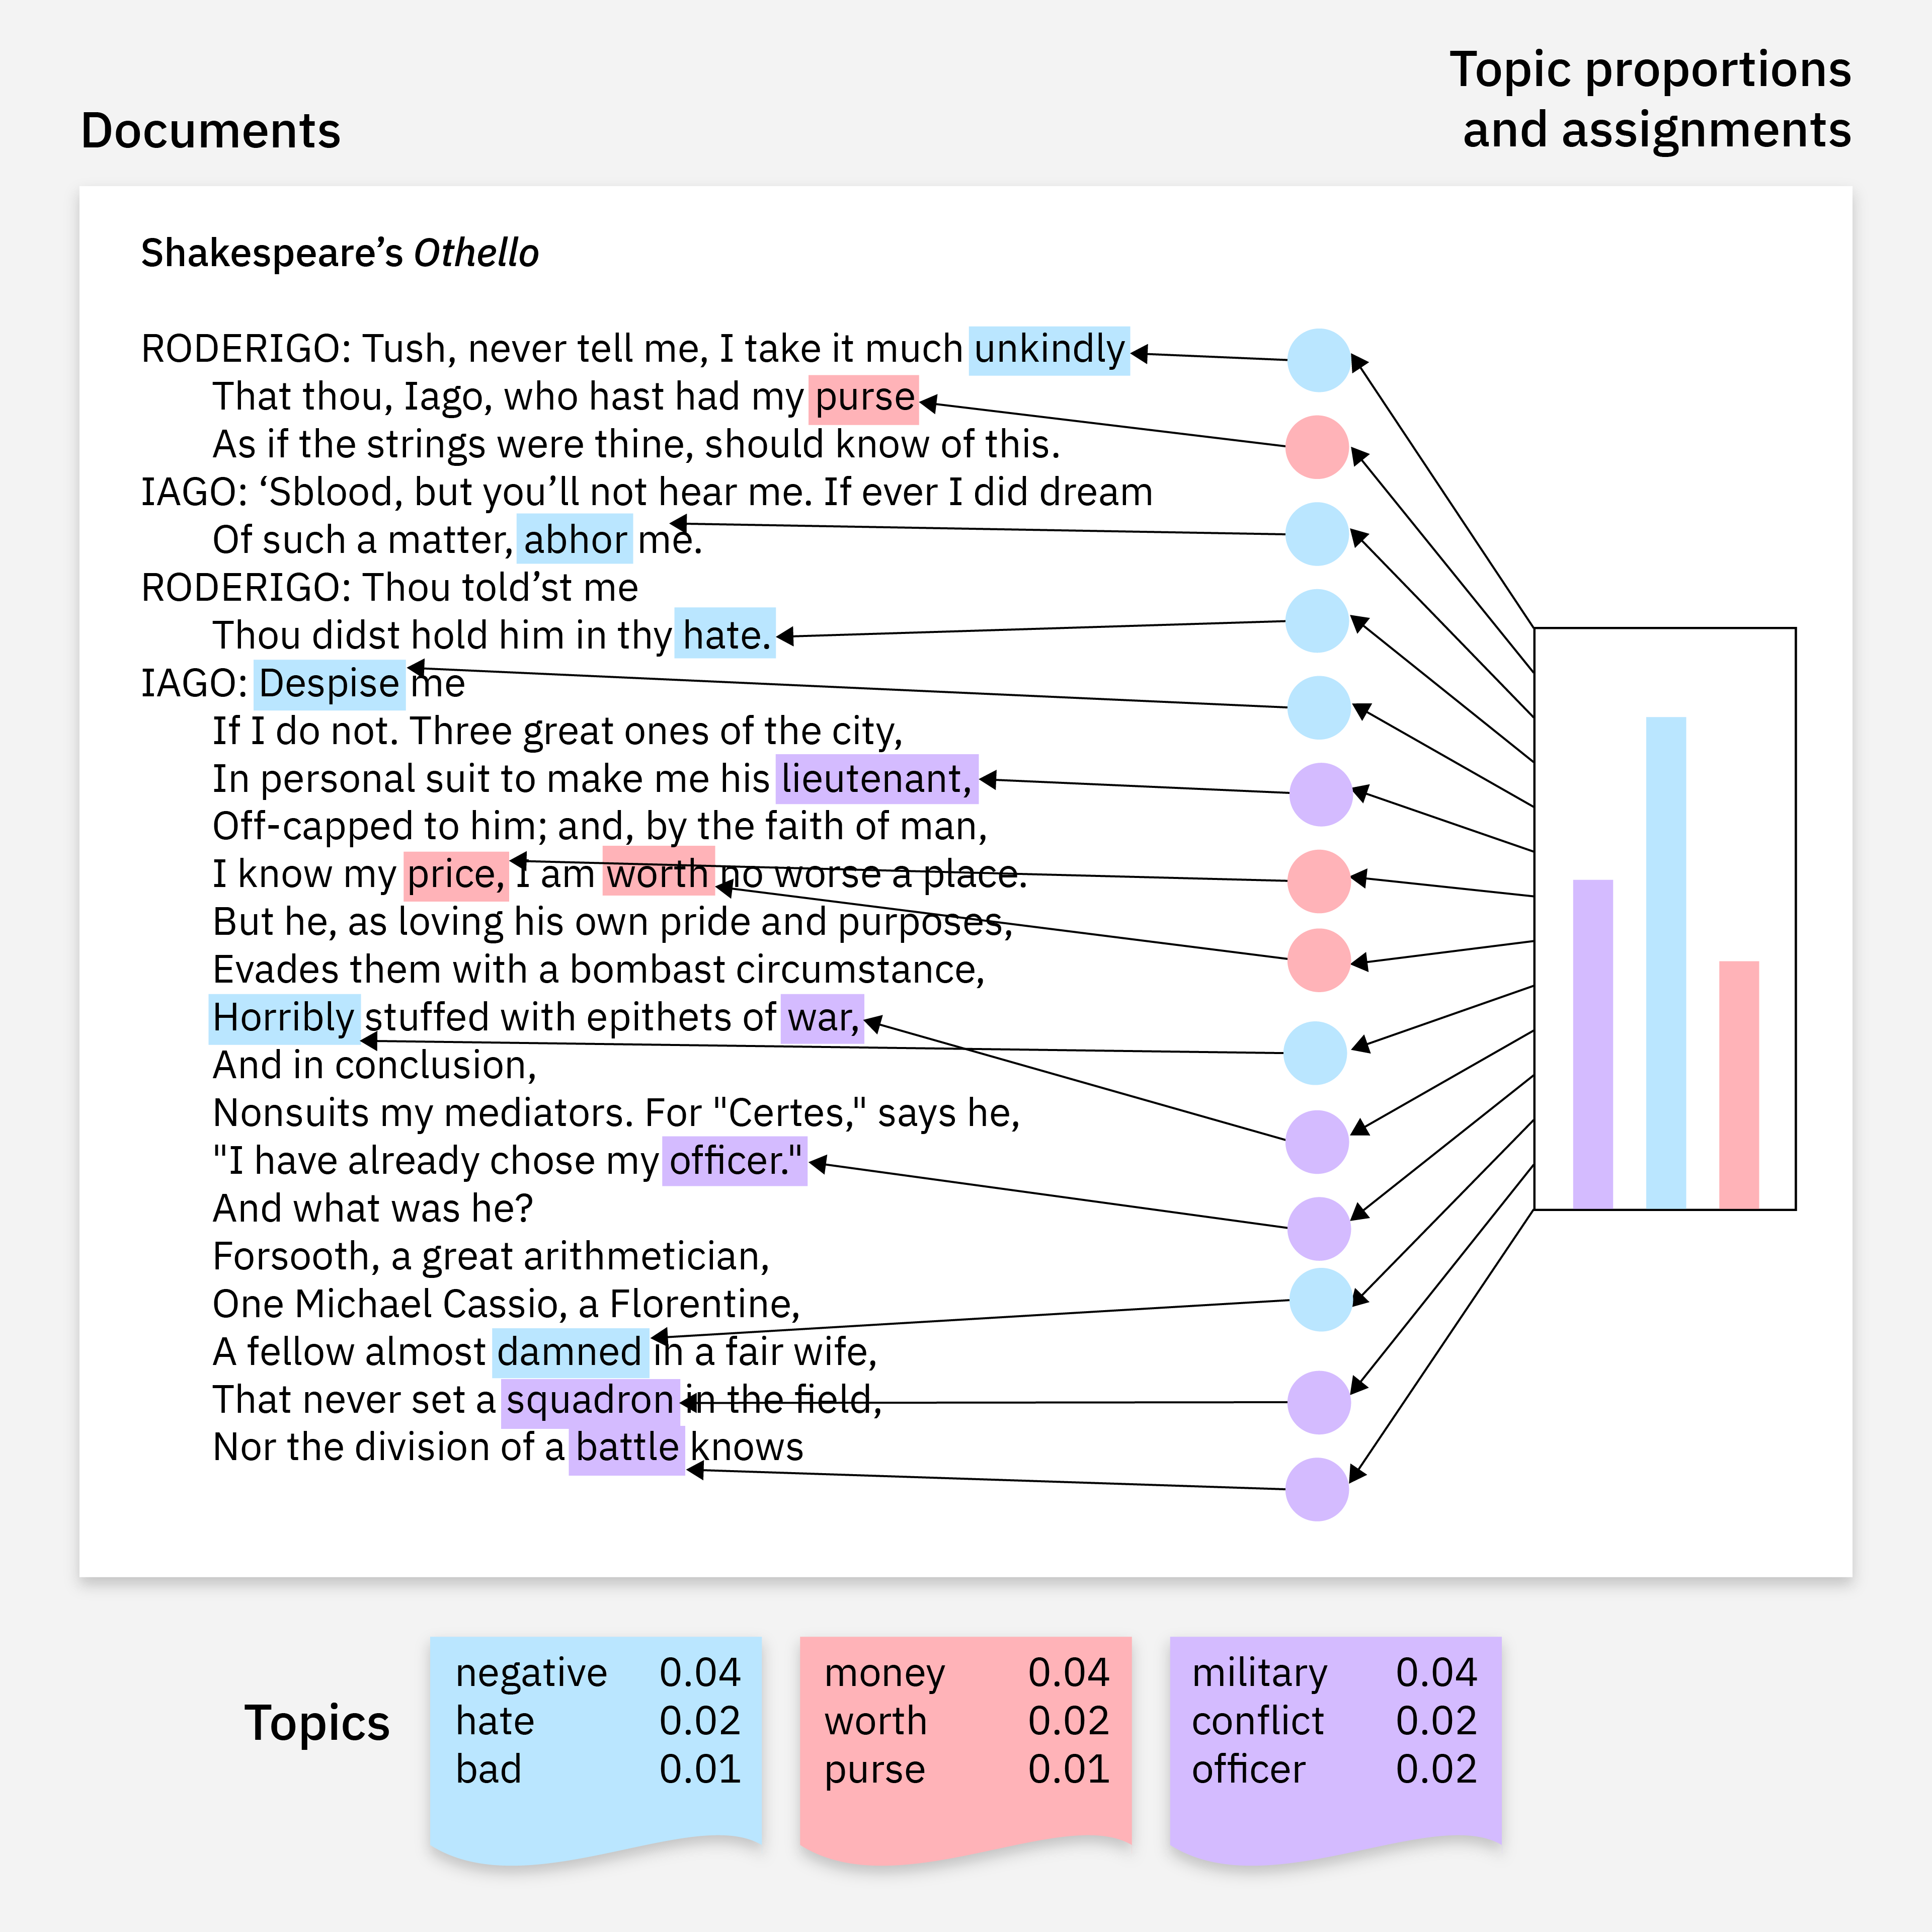

LDA assumes a generative model where each article is written by randomly sampling a topic from a document's topic distribution, and then randomly sampling a word from the chosen topic distribution. So I might write a document where I drew 75% of my words from a "Covid-topic" and 20% from a "election topic" and another 5% from some other random topic. 

Keep in mind that the actual topics here are *latent*: we'll never observe them directly. Instead, we assume they exist and then try to infer their parameters from the distribution of words in each document in the corpus. If our model works, then we should be able to identify topics from our LDA model that have a high probability of several closely related terms.

## Fitting the model

Let's try fitting an LDA model. We need to choose the number of topics ourselves. We'll assume there are 15 topics here. We'll also want to set a `random_state` value. Multiple LDA models with the same number of topics and the same data should find similar topics, but even then the ordering of those topics is arbitrary, so setting the `random_state` variable will ensure that we can replicate our results.



We first create a LatentDirichletAllocation object, then fit it using our document-term-matrix

In [ ]:
# Create LDA model object
k =15
lda = LatentDirichletAllocation(n_components = k, # number of topics. Try different numbers here to see what works best. Usually somewhere between 20 - 100
                                random_state = 123, # random number seed. You can use any number here, but its important to include so you can replicate analysis
                                doc_topic_prior = 1/k) 

# Fit using data (bag_of_words)
doctopic = lda.fit_transform(dfm)

The `doctopic` object has the document topic probabilities in an array. So here's the breakdown of topics in document 0:

In [ ]:
doctopic[0]

In [ ]:
plt.bar(range(k), doctopic[0])

The term distribution for each topic is stored in the `lda.components_` attribute. So here's some top terms from topic 0:

In [ ]:

features[np.argsort(lda.components_[0])[::-1][:10]]

## Interpreting the results

A lot of the complexity of using LDA lies in intepreting the topics themselves. The simplest way to do this is by looking at the most probable words for each topic, which we can do by running the code below:

In [ ]:
# Displaying the top keywords in each topic

n_terms = 10
ls_keywords = []
ls_freqs = []
topic_id = []
    
for i,topic in enumerate(lda.components_):
     # Sorting and finding top keywords
    word_idx = np.argsort(topic)[::-1][:n_terms]
    freqs = list(np.sort(topic)[::-1][:n_terms])
    keywords = [features[i] for i in word_idx]
        
        # Saving keywords and frequencies for later
    ls_keywords = ls_keywords + keywords
    ls_freqs = ls_freqs + freqs
    topic_id = topic_id + [i] * n_terms
        
    
        # Printing top keywords for each topic
    print(i, ', '.join(keywords))
top_words_df = pd.DataFrame({'keywords':ls_keywords, 'frequency':ls_freqs, 'topic_id':topic_id})


In [ ]:
top_words_df

<b style="color:red;"> Question 1: Wrap the code above in a function that takes `n_terms`, `lda`, and `features` as arguments and returns a data frame with the top n terms for each topic in descending order of frequency. Try running the same function with a few different values for `n_terms`</b>

In [ ]:
# define a function here



We can also plot terms by frequency within each topic (although this may get unwieldy for models with a larger number of components)

In [ ]:
sns.catplot(top_words_df, x = 'frequency', y = 'keywords', col = 'topic_id', kind = 'bar', sharey = False, col_wrap=3)


In many cases, an interactive visualization can make it easier to identify topics. The LDAvis package provides an easy way to create an interactive HTML file. 

In [ ]:
panel = pyLDAvis.lda_model.prepare(lda, dfm, vectorizer, mds='tsne', sort_topics=False, n_jobs = -1)
word_info = panel.topic_info

#To save panel in html
pyLDAvis.save_html(panel, 'panel.html')

In the left panel if the display below, you can see each topic scaled by its overall frequency in the corpus. The relative positions of each topic indicates how distinct they are, so that topics that are further apart should share fewer terms. The plot on the right will display top terms for each topic. Instead of using the probability of each term, the displayed in this visualization are ranked according to a metric that accounts for how specific each term is to each topic. In some cases, this can be a better way of identifying the concept each topic represents.

In [ ]:
HTML('panel.html')

<b style="color:red;"> Question 2: Using the information we've gathered so far, see if you can assign a short label to each topic in the LDA model. Replace the generic labels in `label_map` below with some descriptive topic IDs and then recreate the catplot object from the previous section</b>

In [ ]:
label_map = {
    0: 'topic 1',
    1: 'topic 2',
    2: 'topic 3',
    3: 'topic 4',
    4: 'topic 5',
    5: 'topic 6',
    6: 'topic 7',
    7: 'topic 8',
    8: 'topic 9',
    9: 'topic 10',
    10: 'topic 11',
    11: 'topic 12',
    12: 'topic 13',
    13: 'topic 14',
    14: 'topic 15',
}
# map the labels
top_words_df['topic_label'] = top_words_df['topic_id'].map(label_map)

# recreate the catplot object:
sns.catplot(top_words_df, x = 'frequency', y = 'keywords', col = 'topic_label', kind = 'bar', sharey = False, col_wrap=3)

## Identifying Document Topics

Remember that LDA gives us two distributions: a distribution for word occurrences in each topic, and a distribution of topic occurrences within each document. So we also have a way to see what documents are associated with what sources or what time periods. We just need to link the topic memberships in `doctopic` back to the original documents so that we can see which documents are getting categorized into which topics:

In [ ]:
topic_memberships = pd.DataFrame(doctopic)
topic_memberships.columns = ["topic " + str(i)  for i in topic_memberships.columns ]
topic_memberships.head()

Each row in this result represents one of the documents from our original data, and each column represents a topic. We can make things a little easier to interpret by appending some information about each article as additional columns onto this data frame:

In [ ]:
topic_memberships['text'] = articles.text
topic_memberships['source'] = articles.source
topic_memberships['headline'] =articles.headline
topic_memberships['url'] = articles.url
topic_memberships['hyperlink'] = articles.hyperlink

topic_memberships.head()

<b style="color:red;"> Question 3: Identify the top 5 articles most strongly associated with topic 6</b>

In [ ]:
# 



<b style="color:red;"> Question 4: Which topics, if any, occurred more often in Fox News stories vs. CNN?</b>

In [ ]:
#


# Making a styled table

Since we included a hyperlink and an article title in our original data frame, we can make a styled table that includes a formatted link for the topic articles in each topic.

In [ ]:
n_terms = 10
n_docs = 3
top_documents = []
top_index = topic_memberships.columns.values.tolist()[:15]
for i, label in enumerate(top_index):
    top_n_documents =  topic_memberships.sort_values(label, ascending=False).head()
    terms={ 'topic' : i,
           'mean proportion' : np.mean(topic_memberships[label]),
        'docs' : '<br>'.join([i for i in top_n_documents['hyperlink'].to_list()[:n_docs]]),
        'terms' : ', '.join([features[j] for j in np.argsort(lda.components_[i])[::-1][:n_terms]]) 
    }
    top_documents.append(terms)



In [ ]:
pd.DataFrame(top_documents).sort_values(['mean proportion'], ascending=False).reset_index(drop=True).style

<b style="color:red;"> Question 5: Try re-running the model with a larger number of topics. Compare your results. </b>

# Other visualizations


There are a lot of cool packages for visualization the results from topic models! Here's one called topic wizard that's got some really cool options for making sense of your results. Unfortunately, it doesn't appear to work inside a jupyter notebook, so this is only a viable option if you have a local version of Python installed on your computer.  

In [ ]:
import topicwizard
from topicwizard.pipeline import make_topic_pipeline
topic_pipeline = make_topic_pipeline(vectorizer, lda)
topicwizard.visualize(articles.text, model=topic_pipeline)

In [ ]:
%pip install topic-wizard